# 1. 全连接卷积神经网络FCN

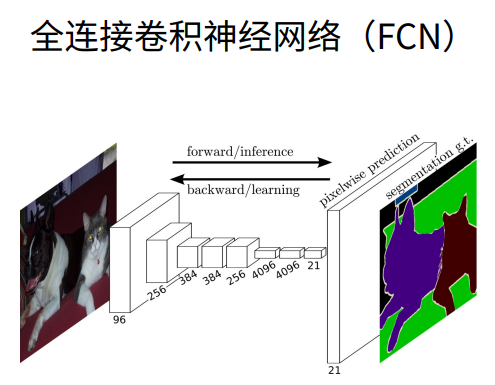

① 1 * 1 卷积层来降低维度。

② 转置卷积层把图片扩大，k是通道有多少类，通道数为类别数，则导致可以对每一个像素分类。

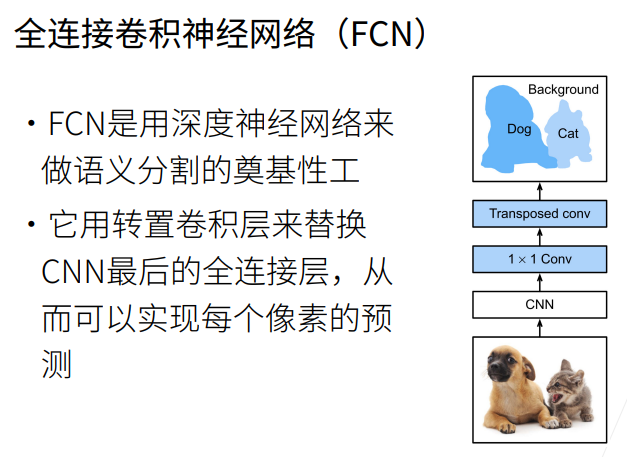

# 2. 全连接卷积神经网络FCN 

# 核心内容详解

Markdown中提到的两个核心步骤分别是：
1. **1x1 卷积层（降维）**
2. **转置卷积层（放大图片/上采样）**

## 1. 关于“① 1 * 1 卷积层来降低维度”

### 这是什么意思？
在深度学习网络（比如ResNet）中，经过层层卷积和池化后，图像的尺寸变小了，但特征通道数（Channel）变得非常多。
例如，一张照片输入ResNet，最后输出的特征图可能只有原图的1/32大小，但厚度（通道数）却有512层。
这里的“1x1卷积”就像一个**压缩器**，它不改变图片的长宽，只改变“厚度”。

### 为什么要这么做？
我们需要把这512个抽象的特征通道，转换成我们具体的分类类别数。
比如我们要分21类（20种物体+1个背景），我们就用1x1卷积把512个通道“揉”成21个通道。

### 简单例子：
想象你有一叠512页的复杂的分析报告（512个通道），每页都从不同角度描述这张图。
但你的老板只想看最后的结论：这张图里到底有哪些东西？（比如只需要分：猫、狗、背景 3类）。
于是你找了个助手（1x1卷积），让他把这512页报告总结成一张只有3页的简报：
* 第1页：哪里像猫的概率高。
* 第2页：哪里像狗的概率高。
* 第3页：哪里像背景的概率高。
**这就叫“降低维度”（从512维降到3维）。**

---

## 2. 关于“② 转置卷积层把图片扩大”

### 这是什么意思？
Markdown中提到：“转置卷积层把图片扩大，k是通道有多少类，通道数为类别数，则导致可以对每一个像素分类。”
经过前面的处理，虽然我们有了分类信息，但图片尺寸太小了（比如原图是320x480，现在可能只有10x15）。这就像是一张超级马赛克的图，根本看不清轮廓。
**转置卷积（Transposed Convolution）**，也叫反卷积，作用就是**放大图片**（上采样）。

### 为什么要这么做？
语义分割的任务是给**原图**的每个像素分类。所以我们需要把那个小小的特征图，放大回原图的尺寸（320x480）。
同时，保持通道数不变（还是21个类别通道）。

### 简单例子（接上文）：
刚才助手给你的那3页简报（猫、狗、背景概率图），虽然信息对了，但只有邮票那么大（10x15像素），根本没法盖在原图上对比。
你需要一个放大镜（转置卷积），把这3页简报投影放大，变回和原图一样大（320x480像素）。
这样，你拿着放大后的：
* “猫页”盖在原图上，发现左下角数值很高 -> **判定：左下角这些像素是猫！**
* “狗页”盖在原图上，发现右上角数值很高 -> **判定：右上角这些像素是狗！**
这就实现了**“对每一个像素分类”**。

---

## 总结流程图

为了帮你理清思路，我们可以把整个过程看作一个**“压缩-总结-还原”**的流水线：

1. **输入原图** (320x480像素)
   ↓
2. **骨干网络 (ResNet)**：提取特征，图片变小，变厚 (10x15像素, 512层特征)
   ↓
3. **1x1 卷积 (降维)**：把特征总结为类别 (10x15像素, 21层类别概率) —— *对应Markdown第①点*
   ↓
4. **转置卷积 (放大)**：把图片放大回原尺寸 (320x480像素, 21层类别概率) —— *对应Markdown第②点*
   ↓
5. **输出结果**：对每个像素取21层中概率最大的那一层，确定该像素的类别。

这就是这段Markdown想要传达的核心思想：**利用1x1卷积进行类别映射，利用转置卷积恢复尺寸，最终实现像素级的分类。**

In [1]:
import torch
import torchvision
from torch import nn
from torch.nn import functional as F

In [2]:
# [语法]: 导入 torchvision.models 模块 (假设前面已经 import torchvision)
# [作用]: ResNet18 是一个非常经典的 18 层残差网络，torchvision 库里内置了这个模型结构。
# 参数 pretrained=True:
#   [语法]: 关键字参数 (Keyword Argument)。
#   [作用]: 告诉 PyTorch：“别给我一个空壳子，我要那个在 ImageNet (1000万张图) 上训练好的大神模型。”
#          这样下载下来的模型，权重(Weights)已经是有意义的，而不是随机初始化的。
pretrained_net = torchvision.models.resnet18(pretrained=True)

# [语法]: 链式调用 + 类型转换 + 切片操作。
# 这行代码其实干了三件事：
# 1. pretrained_net.children():
#    [语法]: PyTorch 模型的方法 (Method)。
#    [作用]: 获取模型里的第一级子模块 (Sub-modules)。
#           对于 ResNet，它的子模块包括：Conv1, BatchNorm, ReLU, MaxPool, Layer1, Layer2, Layer3, Layer4, AvgPool, FC。
#           注意：它返回的是一个“迭代器” (Iterator)，你看不到里面的内容，只能一个一个取。

# 2. list(...):
#    [语法]: Python 内置函数。
#    [作用]: 把上面的“迭代器”强行展开，变成一个 Python 列表 (List)。
#           这样我们就可以用索引 (Index) 来访问它了。

# 3. [-3:]:
#    [语法]: Python 列表切片 (Slicing)。
#    [作用]: 取出列表中“倒数第3个”到“最后”的所有元素。
#           ResNet18 的最后三层分别是：
#           (倒数第3): Layer4 (包含好几个残差块)
#           (倒数第2): AdaptiveAvgPool2d (全局平均池化层)
#           (倒数第1): Linear (全连接层，用于分类)
list(pretrained_net.children())[-3:] 
# [作用]: 打印出来看看。
# 目的: 我们做 FCN 时，通常要把“倒数第2层(池化)”和“倒数第1层(全连接)”删掉，只保留“倒数第3层”及之前的卷积层。
# 所以看这行代码的输出，是为了确认我们切刀的位置对不对。

d:\python3.12\Anaconda\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\python3.12\Anaconda\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[Sequential(
   (0): BasicBlock(
     (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (downsample): Sequential(
       (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
       (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     )
   )
   (1): BasicBlock(
     (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): Batc

In [3]:
# [语法]: 组合式写法：list转换 + 切片 + 星号解包 + nn.Sequential容器。
# 1. list(pretrained_net.children()): 获取 ResNet18 所有子层（迭代器）并转为列表。
# 2. [:-2]: 列表切片，保留从第1个到倒数第3个元素，**扔掉最后两个元素**（即 AvgPool池化层 和 FC全连接层）。
# 3. *: 解包操作符 (Unpacking)。把列表里的 [Layer1, Layer2...] 变成一个个独立的参数传给 nn.Sequential。
# 4. nn.Sequential(...): PyTorch 的容器，把传进来的层按顺序串联起来，组成一个新的网络。
net = nn.Sequential(*list(pretrained_net.children())[:-2]) 
# [作用]: 构建骨干网络 (Backbone)。
# 我们只要 ResNet18 提取特征的能力（前面的卷积层），不需要它做分类（后面的全连接层）。
# 这样构建出的 net，输入是图片，输出是深层的特征图 (Feature Map)。


# [语法]: torch.rand(size=...)。
# 1. torch.rand: 生成服从 0~1 均匀分布的随机数。
# 2. size=(1, 3, 320, 480): 指定张量形状 [Batch_Size, Channels, Height, Width]。
X = torch.rand(size=(1, 3, 320, 480)) 
# [作用]: 创建一个“假数据” (Dummy Input) 用于测试。
# 模拟一张 320x480 的彩色图片（3通道），且 Batch Size 为 1。
# 用它来跑一遍网络，看看能不能通，以及输出变成什么样了。


# [语法]: 对象调用 (Callable) + 属性访问。
# 1. net(X): 调用 net 的 forward 方法，执行前向传播计算。
# 2. .shape: 获取输出张量的维度信息。
net(X).shape 
# [作用]: 检查特征图的尺寸 (下采样倍率)。
# 预期结果: torch.Size([1, 512, 10, 15])
# 分析:
#   - 1: Batch Size 不变。
#   - 512: ResNet18 最后一层卷积（layer4）的输出通道数是 512。
#   - 10: 高度 320 / 32 = 10。
#   - 15: 宽度 480 / 32 = 15。
# 结论: 这个网络会把图片长宽各缩小 32 倍 (32x Downsampling)。

torch.Size([1, 512, 10, 15])

In [4]:
# [语法]: 变量赋值。
# [作用]: 定义最终的分类数量。Pascal VOC 数据集有 20 类物体 + 1 类背景 = 21 类。
num_classes = 21

# [语法]: add_module('名字', 层对象)。
# [作用]: 给之前的 net (Sequential) 再追加一层。
# nn.Conv2d(512, num_classes, kernel_size=1):
#   - 512: 输入通道数。因为 ResNet18 最后一层的输出是 512 个通道。
#   - num_classes (21): 输出通道数。我们需要把 512 个抽象特征变成 21 个类别的概率得分。
#   - kernel_size=1: 1x1 卷积。它不改变图片长宽，只改变通道数 (降维)。
net.add_module('final_conv', nn.Conv2d(512, num_classes, kernel_size=1))
# [语法]: net.add_module 追加层。
# nn.ConvTranspose2d(...): 转置卷积层 (反卷积)。
net.add_module('transpose_conv', nn.ConvTranspose2d(
    in_channels=num_classes,  # [语法]: 输入通道 21。因为上一层输出了 21 个类别的分数。
    out_channels=num_classes, # [语法]: 输出通道 21。放大后依然保持 21 个类别的分数。
    kernel_size=64,           # [作用]: 卷积核大小。决定了放大的视野范围。
    padding=16,               # [作用]: 填充。为了抵消卷积核边缘效应，保持尺寸对齐。
    stride=32                 # [作用]: 步幅。★最关键★ 步幅为 32 意味着图片长宽放大 32 倍。
))


### 🧠 深度解析：为什么是 kernel=64, padding=16, stride=32？

这里的目标是：**将图片放大 32 倍**。

在深度学习中，转置卷积（Transposed Convolution）的输出尺寸公式（简化版）是：

$$Output = (Input - 1) \times Stride - 2 \times Padding + Kernel$$

我们希望实现的放大效果是：
$$Output = Input \times 32$$

将这个目标带入公式推导：

$$Input \times 32 = (Input - 1) \times 32 - 2 \times Padding + Kernel$$

展开括号：
$$Input \times 32 = Input \times 32 - 32 - 2 \times Padding + Kernel$$

两边消去 $Input \times 32$：
$$0 = -32 - 2 \times Padding + Kernel$$

移项得到核心关系式：
$$Kernel = 2 \times Padding + 32$$

---

**所以，只要满足 $Kernel = 2 \times Padding + 32$ 这个关系，就能完美放大 32 倍且对齐像素。**

#### ✅ 常用的组合 1 (本代码采用)
* **参数**：$Stride=32, \ Padding=16$
* **计算 Kernel**：
  $$Kernel = 2 \times 16 + 32 = 64$$
* **特点**：核比较大，重叠区域多，生成的图像比较平滑（棋盘效应较弱）。

#### ❎ 常用的组合 2 (最小核)
* **参数**：$Stride=32, \ Padding=0$
* **计算 Kernel**：
  $$Kernel = 2 \times 0 + 32 = 32$$
* **特点**：核最小，计算最快，但就像把像素直接拉大，会有明显的“马赛克块”（棋盘效应严重）。

---

**总结**：代码选用 `kernel=64, padding=16, stride=32` 是为了获得**更平滑、更高质量**的放大效果，同时保证数学上精确放大 32 倍。

In [5]:
# [语法]: 定义函数 bilinear_kernel。
# [作用]: 生成一个用于初始化的权重矩阵 (Weight Tensor)。
# 参数:
#   in_channels: 输入通道数 (比如 21)。
#   out_channels: 输出通道数 (比如 21)。
#   kernel_size: 卷积核大小 (比如 64)。
def bilinear_kernel(in_channels, out_channels, kernel_size):
    
    # [语法]: 整数除法 //。
    # [作用]: 计算“半个核”的大小 (factor)。
    # 它是双线性插值公式里的分母，用来归一化距离。
    # 比如 kernel=4, factor=2; kernel=3, factor=2。
    factor = (kernel_size + 1) // 2
    
    # [语法]: if-else 判断奇偶性。
    # [作用]: 确定卷积核的几何中心坐标 (center)。
    # 双线性插值是基于“距离中心点的远近”来分配权重的，所以必须先找到中心。
    if kernel_size % 2 == 1:
        # [语法]: 奇数情况。
        # [作用]: 比如 kernel=3 (索引0,1,2)，中心点就在索引 1.0 处。
        center = factor - 1
    else:
        # [语法]: 偶数情况。
        # [作用]: 比如 kernel=4 (索引0,1,2,3)，几何中心在索引 1.5 处。
        # 深度学习中常用偶数核 (如64) 进行上采样，所以这里 center 通常是小数。
        center = factor - 0.5
        
    # [语法]: 元组创建 + torch.arange + reshape。
    # 1. torch.arange(kernel_size): 生成 [0, 1, 2, ..., 63] 的序列。
    # 2. reshape(-1, 1): 变成列向量 (64x1)。
    # 3. reshape(1, -1): 变成行向量 (1x64)。
    # [作用]: 生成两个网格坐标向量 og (grid)，分别代表行坐标(x)和列坐标(y)。
    # 为了后面通过广播机制 (Broadcasting) 计算每个点到中心的距离。
    og = (torch.arange(kernel_size).reshape(1, -1),
          torch.arange(kernel_size).reshape(-1, 1))

    # [语法]: 张量数学运算 (广播机制)。
    # 公式: (1 - |x - center| / factor) * (1 - |y - center| / factor)
    # [作用]: 【核心数学公式】计算双线性插值滤波器 (Filter)。
    # 这是一个 2D 的金字塔形状：中心点是 1，越往边缘越接近 0。
    # filt 的形状是 (kernel_size, kernel_size)，比如 (64, 64)。
    filt = (1 - torch.abs(og[0] - center) / factor) * (1 - torch.abs(og[1] - center) / factor)
    # 核心逻辑是:离中心点越近,权重越高
    
    # [语法]: torch.zeros 创建全零张量。
    # [作用]: 初始化最终的权重矩阵。
    # 形状: (输入通道, 输出通道, 高, 宽)。
    # 注意: 转置卷积权重的形状定义通常是 (in, out, k, k)。
    weight = torch.zeros((in_channels, out_channels, kernel_size, kernel_size))
    
    # [语法]: 高级索引赋值 (Advanced Indexing)。
    # range(in_channels): [0, 1, ..., 20]
    # [作用]: 把刚才算出来的 2D 滤波器 (filt)，填入到权重矩阵的对角线上。
    # 含义: 第 i 个输入通道，只负责缩放第 i 个输出通道，不干扰其他通道。
    # 这相当于做了一个 "Depthwise" 的初始化。
    weight[range(in_channels), range(out_channels), :, :] = filt
    
    # [语法]: 返回张量。
    # [作用]: 把这个做好的“初始化大礼包”扔回去，给 model.transpose_conv.weight.data 用。
    return weight

Input shape: torch.Size([561, 728, 3])
Output shape: torch.Size([1122, 1456, 3])


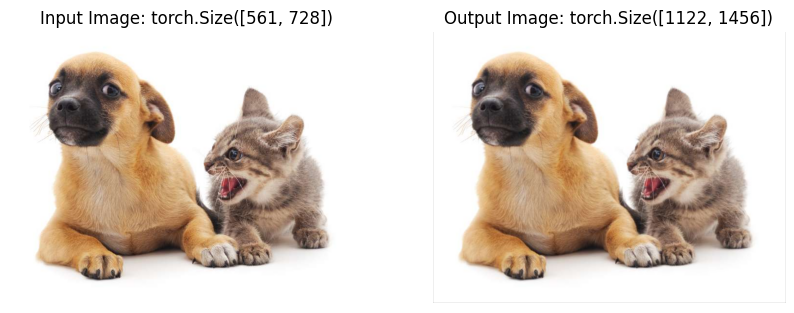

In [6]:
# 双线性插值的上采样实验
# 创建一个转置卷积层，输入和输出通道数都是3，这是因为我们处理的是RGB图片，每个颜色通道都需要进行处理
# 核大小是4，步长是2，这意味着这个层将输入的宽度和高度放大了2倍
# 设置bias为False，因为我们不需要偏置项
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image  # 替代 d2l.Image
import matplotlib.pyplot as plt  # 替代 d2l.plt

# ==========================================
# 2. 核心实验代码 (去除 d2l)
# ==========================================

# [语法]: 实例化 ConvTranspose2d 类
# [作用]: 创建一个转置卷积层。
# 参数解析:
# - 3, 3: 输入 RGB 3通道，输出也是 RGB 3通道。
# - kernel_size=4, stride=2, padding=1: ★黄金组合★
#   公式: Output = (Input-1)*Stride + Kernel - 2*Padding
#   Output = (Input-1)*2 + 4 - 2*1 = 2*Input。
#   结论: 无论图片多大，宽高都会精确放大 2 倍。
# - bias=False: 双线性插值是纯数学计算，不需要偏置项干扰。
conv_trans = nn.ConvTranspose2d(3, 3, kernel_size=4, padding=1, stride=2, bias=False)

# [语法]: .data.copy_(...)
# [作用]: 初始化权重。
# .data: 访问权重的底层数据张量。
# .copy_(): 原地操作 (In-place)，把生成的双线性核覆盖进去。
# 结果: 这个卷积层现在不是随机初始化的了，它变成了一个“双线性插值放大器”。
conv_trans.weight.data = conv_trans.weight.data.copy_(bilinear_kernel(3, 3, 4))

# [语法]: Image.open(...)
# [作用]: 使用 PIL 库读取图片文件。
# (注意：请确保你当前目录下有这张图，或者换成你电脑里随便一张图片的路径)
img_pil = Image.open(r'D:\深度学习\200_李沐数据集\01_Data\03_catdog.jpg') 

# [语法]: transforms.ToTensor()(img_pil)
# [作用]: 预处理。
# 1. 把图片从 PIL 格式 (H, W, C) 转为 Tensor 格式 (C, H, W)。
# 2. 把数值从 [0, 255] 归一化到 [0.0, 1.0]。
img_tensor = transforms.ToTensor()(img_pil)

# [语法]: .unsqueeze(0)
# [作用]: 增加 Batch 维度。
# PyTorch 的层只吃 4 维数据 [Batch, Channel, Height, Width]。
# 现在的形状从 [3, H, W] 变成了 [1, 3, H, W]。
X = img_tensor.unsqueeze(0)
# 0 是位置索引

# [语法]: conv_trans(X)
# [作用]: 前向传播 (Forward)。
# 数据流过转置卷积层，执行“放大2倍”的操作。
# Y 的形状应该是 [1, 3, 2H, 2W]。
Y = conv_trans(X)

# [语法]: 链式操作 .permute(...).detach()
# [作用]: 后处理，为了画图。
# 1. Y[0]: 取出 batch 里的第一张图，形状 [3, 2H, 2W]。
# 2. .permute(1, 2, 0): 维度重排。Matplotlib 画图要求是 (高, 宽, 通道)，所以要把 C 移到最后。
#    形状变为 [2H, 2W, 3]。
# 3. .detach(): 从计算图中剥离。因为 Y 是模型输出，带着梯度信息，转 numpy 前必须切断梯度。
out_img = Y[0].permute(1, 2, 0).detach()
#必须剥离，因为带着计算图

# --- 下面是画图部分 (替代 d2l.plt) ---

# [语法]: plt.subplots(...)
# [作用]: 创建一个画布，里面包含 1 行 2 列的子图。
# figsize=(10, 5) 设置画布总宽 10 inch，高 5 inch。
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# [语法]: axes[0].imshow(...)
# [作用]: 在左边的子图里画原始图片。
# img_tensor.permute(1,2,0) 是为了把 (C,H,W) 转回 (H,W,C) 给 plt 显示。
axes[0].imshow(img_tensor.permute(1, 2, 0))
axes[0].set_title(f'Input Image: {img_tensor.shape[1:]}') # 设置标题显示尺寸
axes[0].axis('off')

# [语法]: axes[1].imshow(...)
# [作用]: 在右边的子图里画放大后的图片。
axes[1].imshow(out_img)
axes[1].set_title(f'Output Image: {out_img.shape[:2]}') # 设置标题显示尺寸
axes[1].axis('off')

# [语法]: print(...)
# [作用]: 打印日志，再次确认尺寸是否真的变大了。
print('Input shape:', img_tensor.permute(1, 2, 0).shape)
print('Output shape:', out_img.shape)

# [语法]: plt.show()
# [作用]: 弹出窗口显示图片。
plt.show()

In [7]:
# 用双线性插值的上采样初始化转置卷积层
# 对于1X1卷积层，我们使用Xavier初始化参数
# 使用双线性插值核初始化转置卷积层的权重
# num_classes是目标数据集中的类别数量，这里使用双线性插值核的尺寸为64
W = bilinear_kernel(num_classes, num_classes, 64)
nn.init.xavier_uniform_(net.final_conv.weight)
# 将初始化的权重W复制给转置卷积层的权重
# 使用copy_方法进行就地操作，直接修改原始张量的值
net.transpose_conv.weight.data.copy_(W)

tensor([[[[0.0002, 0.0007, 0.0012,  ..., 0.0012, 0.0007, 0.0002],
          [0.0007, 0.0022, 0.0037,  ..., 0.0037, 0.0022, 0.0007],
          [0.0012, 0.0037, 0.0061,  ..., 0.0061, 0.0037, 0.0012],
          ...,
          [0.0012, 0.0037, 0.0061,  ..., 0.0061, 0.0037, 0.0012],
          [0.0007, 0.0022, 0.0037,  ..., 0.0037, 0.0022, 0.0007],
          [0.0002, 0.0007, 0.0012,  ..., 0.0012, 0.0007, 0.0002]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0

In [8]:
# [语法]: import 库名
# [作用]: 导入 PyTorch 深度学习核心库。
# 它是所有工作的地基，提供了张量 (Tensor) 数据结构、自动求导 (Autograd) 和 GPU 加速功能。
import torch

# [语法]: import 库名
# [作用]: 导入 PyTorch 的计算机视觉工具包。
# 这里面装满了宝贝：官方数据集 (datasets)、预训练模型 (models, 如 ResNet)、图像变换工具 (transforms)。
import torchvision

# [语法]: from 子模块 import 类
# [作用]: 导入“数据加载器” (DataLoader)。
# 它是 PyTorch 数据管道的运输大队长。它负责：
# 1. 把零散的数据打包成批次 (Batch)。
# 2. 也就是每次喂给模型 32 或 64 张图。
# 3. 负责打乱数据顺序 (Shuffle) 和多进程并行加载 (num_workers)。
from torch.utils.data import DataLoader

# [语法]: import 模块 as 别名
# [作用]: 导入图像预处理模块，并给它起个短名字叫 transforms。
# 它是我们的“修图工具箱”，里面有 Resize (缩放), ToTensor (转张量), Normalize (归一化) 等常用工具。
import torchvision.transforms as transforms

# [语法]: from 模块 import 枚举类
# [作用]: 导入“插值模式”枚举。
# 在调整图像尺寸 (Resize) 时，电脑需要决定新像素的值怎么算。
# 1. 对普通图片：通常用 InterpolationMode.BILINEAR (双线性插值)，让画面平滑。
# 2. 对标签图片：★必须★用 InterpolationMode.NEAREST (最近邻插值)，保证类别 ID (0, 1, 2) 不变，不产生小数。
from torchvision.transforms import InterpolationMode

# ==========================================
# 1. 定义超参数
# ==========================================
# [语法]: 变量赋值
# [作用]: 定义批大小为32，裁剪尺寸为高320、宽480。
batch_size, crop_size = 32, (320, 480)


# ==========================================
# 2. 定义图像和标签的预处理 (Transforms)
# ==========================================
# 注意：标准的 transforms 不能自动同步变换（即保证图片和标签裁同一个位置）。
# 为了代码简洁易懂，这里用 Resize (缩放) 代替 RandomCrop (随机裁剪)。
# 如果必须用 RandomCrop，通常需要自定义 Dataset 类。

# --- A. 输入图像的变换 ---
# [语法]: transforms.Compose([...]) 将多个步骤串联
# [作用]: 定义针对“原始图片 (X)”的处理流水线。
img_transform = transforms.Compose([
    # [语法]: Resize(size)
    # [作用]: 将图片强行缩放到我们设定的 (320, 480)，保证进入模型的尺寸一致。
    transforms.Resize(crop_size),
    
    # [语法]: ToTensor()
    # [作用]: 1. 将图片从 PIL 格式 (H,W,C) 转为 Tensor (C,H,W)。
    #        2. 将像素值从 [0, 255] 归一化到 [0.0, 1.0]。
    transforms.ToTensor(),
    
    # [语法]: Normalize(mean, std)
    # [作用]: 使用 ImageNet 的均值和方差进行标准化。这是使用预训练 ResNet 的标配。
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# --- B. 标签图像的变换 ---
# [语法]: transforms.Compose([...])
# [作用]: 定义针对“标签图片 (Y)”的处理流水线。
label_transform = transforms.Compose([
    # [语法]: Resize(..., interpolation=InterpolationMode.NEAREST)
    # [作用]: 同样缩放到 (320, 480)。
    # ★关键★: 必须使用 NEAREST (最近邻插值)。
    # 因为标签是 0,1,2... 这种整数类别。如果用默认的双线性插值，边缘会产生 0.5, 1.2 这种小数，
    # 破坏了类别信息，导致报错。
    transforms.Resize(crop_size, interpolation=InterpolationMode.NEAREST),
    
    # [语法]: PILToTensor() (注意不是 ToTensor)
    # [作用]: 将标签转为 Tensor。
    # ★关键★: 必须用 PILToTensor 而不是 ToTensor。
    # 因为 ToTensor 会自动除以 255 变成小数，但我们需要的是 0~21 的整数索引。
    # PILToTensor 保持原始的 uint8 数据类型 (0-255) 不变。
    transforms.PILToTensor() 
])


# ==========================================
# 3. 加载数据集 (Dataset)
# ==========================================

# [语法]: torchvision.datasets.VOCSegmentation(...)
# [作用]: 使用 PyTorch 官方提供的 Pascal VOC 分割数据集接口。
# 参数详解:
# - root='./data': 数据下载/解压的路径。
# - year='2012': 使用 VOC2012 版本。
# - image_set='train': 读取训练集 (train.txt)。
# - download=True: 如果目录下没有数据，自动下载 (约 2GB)。
# - transform=img_transform: 对输入图片应用上面的标准化处理。
# - target_transform=label_transform: 对标签图片应用上面的处理。
voc_train = torchvision.datasets.VOCSegmentation(
    root='D:\\深度学习\\200_李沐数据集\\data', year='2012', image_set='train', download=False, 
    transform=img_transform, target_transform=label_transform)

# [语法]: 同上，但 image_set='val'
# [作用]: 读取验证集 (val.txt) 用于测试/验证。
voc_test = torchvision.datasets.VOCSegmentation(
    root='D:\\深度学习\\200_李沐数据集\\data', year='2012', image_set='val', download=False, 
    transform=img_transform, target_transform=label_transform)

# ==========================================
# 4. 创建数据加载器 (DataLoader)
# ==========================================

# [语法]: DataLoader(...)
# [作用]: 创建训练数据迭代器。
# 参数详解:
# - voc_train: 数据来源。
# - batch_size: 每次给模型喂 32 张图。
# - shuffle=True: ★关键★ 每个 Epoch 开始时打乱数据顺序，防止模型死记硬背。
# - drop_last=True: 如果最后剩下的图片不足 32 张，直接丢掉 (防止形状不匹配报错)。
# - num_workers=4: 使用 4 个 CPU 进程并行加载数据 (加速读取)。
train_iter = DataLoader(voc_train, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=4)

# [语法]: DataLoader(...)
# [作用]: 创建测试数据迭代器。
# - shuffle=False: 测试集不需要打乱顺序。
# - drop_last=True: 也可以设为 False，视具体需求而定。
test_iter = DataLoader(voc_test, batch_size=batch_size, shuffle=False, drop_last=True, num_workers=4)

print("数据加载完成！")

数据加载完成！


In [9]:
import torch
import torch.nn as nn
import time

# ==========================================
# 1. 设备与超参数配置
# ==========================================

# [语法]: 变量赋值 + torch.device() + 三元运算符
# [作用]: 检查电脑是否有 NVIDIA 显卡 (cuda)。如果有，使用第一块显卡 ('cuda:0') 进行加速；否则使用 CPU。
# 这替代了 d2l.try_all_gpus()，是 PyTorch 最标准的写法。
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# [语法]: 变量赋值
# [作用]: 设置训练参数：学习率 0.001，权重衰减 1e-3 (防止过拟合)，训练 5 轮。
lr, wd, num_epochs = 0.001, 1e-3, 5

# [语法]: 模型方法 .to(device)
# [作用]: 将神经网络的所有参数（权重和偏置）搬运到指定的设备（显卡显存或内存）上。
# 注意：这一步必须在定义优化器之前做。
net = net.to(device)

# ==========================================
# 2. 定义优化器与损失函数
# ==========================================

# [语法]: torch.optim.SGD(参数迭代器, 关键字参数...)
# [作用]: 初始化随机梯度下降优化器。
# 它负责持有网络的所有参数 (net.parameters())，并在后续通过 .step() 更新这些参数。
optimizer = torch.optim.SGD(net.parameters(), lr=lr, weight_decay=wd)

# [语法]: nn.CrossEntropyLoss(reduction='mean')
# [作用]: 定义损失函数。
# 相比你代码里手动写的 loss 函数，这是官方标准实现。
# 它会自动对 Softmax、Log、NLLLoss 进行合并计算，并默认对 Batch 里所有像素的 Loss 求平均，输出一个标量 (Scalar)。
# [语法]: ignore_index=255
# [作用]: 告诉损失函数，如果标签里的值是 255，就直接跳过，不要计算梯度，也不要报错。
# 这相当于把 255 当作透明的空气。
criterion = nn.CrossEntropyLoss(reduction='mean', ignore_index=255)
criterion.to(device)
# ==========================================
# 3. 训练循环 (替代 d2l.train_ch13)
# ==========================================

print(f'Training on {device}...')

# [语法]: for 循环
# [作用]: 外层循环，控制训练的轮数 (Epoch)。每跑完一圈，意味着模型把整个数据集看了一遍。
for epoch in range(num_epochs):
    
    # [语法]: 模型方法 .train()
    # [作用]: 将模型切换到“训练模式”。
    # 这对于 BatchNorm 层和 Dropout 层非常重要，告诉它们现在要更新参数，而不是冻结状态。
    net.train()
    
    # [语法]: 变量初始化
    # [作用]: 用于记录当前 Epoch 的总损失和已处理的批次数量，方便最后打印日志。
    total_loss = 0.0
    num_batches = 0
    
    # [语法]: for 循环 + enumerate(迭代器)
    # [作用]: 内层循环，从 DataLoader (train_iter) 中一波一波地取数据。
    # i 是索引，(X, y) 是这一个 Batch 的图片和标签。
    for i, (X, y) in enumerate(train_iter):
        
        # [语法]: 张量方法 .to(device)
        # [作用]: 将数据搬运到和模型同一个设备上 (GPU)。
        # 这是一个非常容易报错的地方：模型在 GPU，数据如果还在 CPU，程序会崩。
        X, y = X.to(device), y.to(device)
        
        # [语法]: 优化器方法 .zero_grad()
        # [作用]: 清空过往的梯度。
        # PyTorch 默认会累加梯度。如果不清零，这轮的梯度会和上轮的混在一起，导致更新方向错误。
        optimizer.zero_grad()
        
        # [语法]: 函数调用 (前向传播)
        # [作用]: 将图片 X 喂给网络，计算预测结果 y_hat。
        # 输出形状通常是 (Batch, Class_Num, Height, Width)。
        y_hat = net(X)
        
        # [语法]: 损失函数调用
        # [作用]: 计算预测值 y_hat 和真实标签 y 之间的差距。
        # y.long() 是为了确保标签是整数类型 (int64)，这是交叉熵函数的要求。
        # 注意 y 原本标签是 （batch , c , h , w) 但是在分割任务中，必须是 (batch , h , w)
        l = criterion(y_hat, y.squeeze(1).long())
        
        # [语法]: 张量方法 .backward() (反向传播)
        # [作用]: 也就是“求导”。
        # 它会计算 Loss 对网络中每一个参数的梯度，并将梯度存在参数的 .grad 属性中。
        l.backward()
        
        # [语法]: 优化器方法 .step()
        # [作用]: 更新参数。
        # 根据刚才算出来的梯度和设定的学习率，修改网络的权重：w = w - lr * grad
        optimizer.step()
        
        # [语法]: 累加操作 + .item()
        # [作用]: 累加当前的 Loss 值。
        # .item() 将单元素张量转化为普通的 Python 浮点数，防止显存泄漏。
        total_loss += l.item()
        num_batches += 1
        
        # (可选) 每 50 个 batch 打印一次，看看进度
        if (i + 1) % 50 == 0:
             print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_iter)}], Loss: {l.item():.4f}')

    # [语法]: 格式化字符串打印
    # [作用]: 一个 Epoch 结束后的总结，打印平均损失。
    avg_loss = total_loss / num_batches
    print(f'Epoch [{epoch+1}/{num_epochs}] Finished. Average Loss: {avg_loss:.4f}')

print('训练结束！')

Training on cuda...
Epoch [1/5] Finished. Average Loss: 2.6070
Epoch [2/5] Finished. Average Loss: 1.6514
Epoch [3/5] Finished. Average Loss: 1.3725
Epoch [4/5] Finished. Average Loss: 1.2013
Epoch [5/5] Finished. Average Loss: 1.0925
训练结束！


In [10]:
import torch
import torchvision.transforms as transforms

# ============================================================
# 前置准备：定义标准化转换 (如果你之前代码里已经有了 img_transform，这步可以跳过)
# ============================================================
# [语法]: transforms.Compose 组合变换
# [作用]: 定义标准的 ImageNet 预处理流程：转 Tensor -> 标准化 (减均值除方差)。
# 这是替代 d2l.normalize_image 的核心。
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# ============================================================
# 核心函数：predict (完全剥离 d2l)
# ============================================================
# [语法]: 定义函数 predict，参数 img 是原始图片 (PIL Image 或 numpy array)。
# [作用]: 输入一张原图，输出一张分割好的类别索引矩阵 (2D Tensor)。
def predict(img):
    
    # [语法]: 复合调用：先用 img_transform 处理图片，再用 .unsqueeze(0) 增加维度。
    # [作用]: 数据预处理。
    # 1. img_transform(img): 将原始图片 (H, W, C) 转换为标准化的 Tensor (C, H, W)，值域归一化。
    # 2. .unsqueeze(0): 在第 0 维增加 Batch 维度。
    #    维度变化: [3, H, W] -> [1, 3, H, W]。满足 PyTorch 模型对 4 维输入的硬性要求。
    X = img_transform(img).unsqueeze(0)
    
    # [语法]: 复合调用：X.to(device) -> net() -> .argmax(dim=1)。
    # [作用]: 模型推理。
    # 1. .to(device): 将数据搬运到 GPU (假设你外部定义了 device)。
    # 2. net(...): 前向传播，输出 Logits，形状为 [1, 21, H, W] (假设 21 类)。
    # 3. .argmax(dim=1): 沿着通道维度 (dim=1) 找最大值的索引。
    #    维度变化: [1, 21, H, W] -> [1, H, W]。将概率转换为具体的类别 ID。
    pred = net(X.to(device)).argmax(dim=1)
    
    # [语法]: 张量降维 .squeeze(0)。
    # [作用]: 格式化输出。
    # .squeeze(0) 会移除第 0 维（即 Batch 维度，大小为 1 的维度）。
    # 维度变化: [1, H, W] -> [H, W]。
    # 相比 reshape，squeeze 更安全且语义更明确（就是为了挤掉 batch）。
    return pred.squeeze(0)

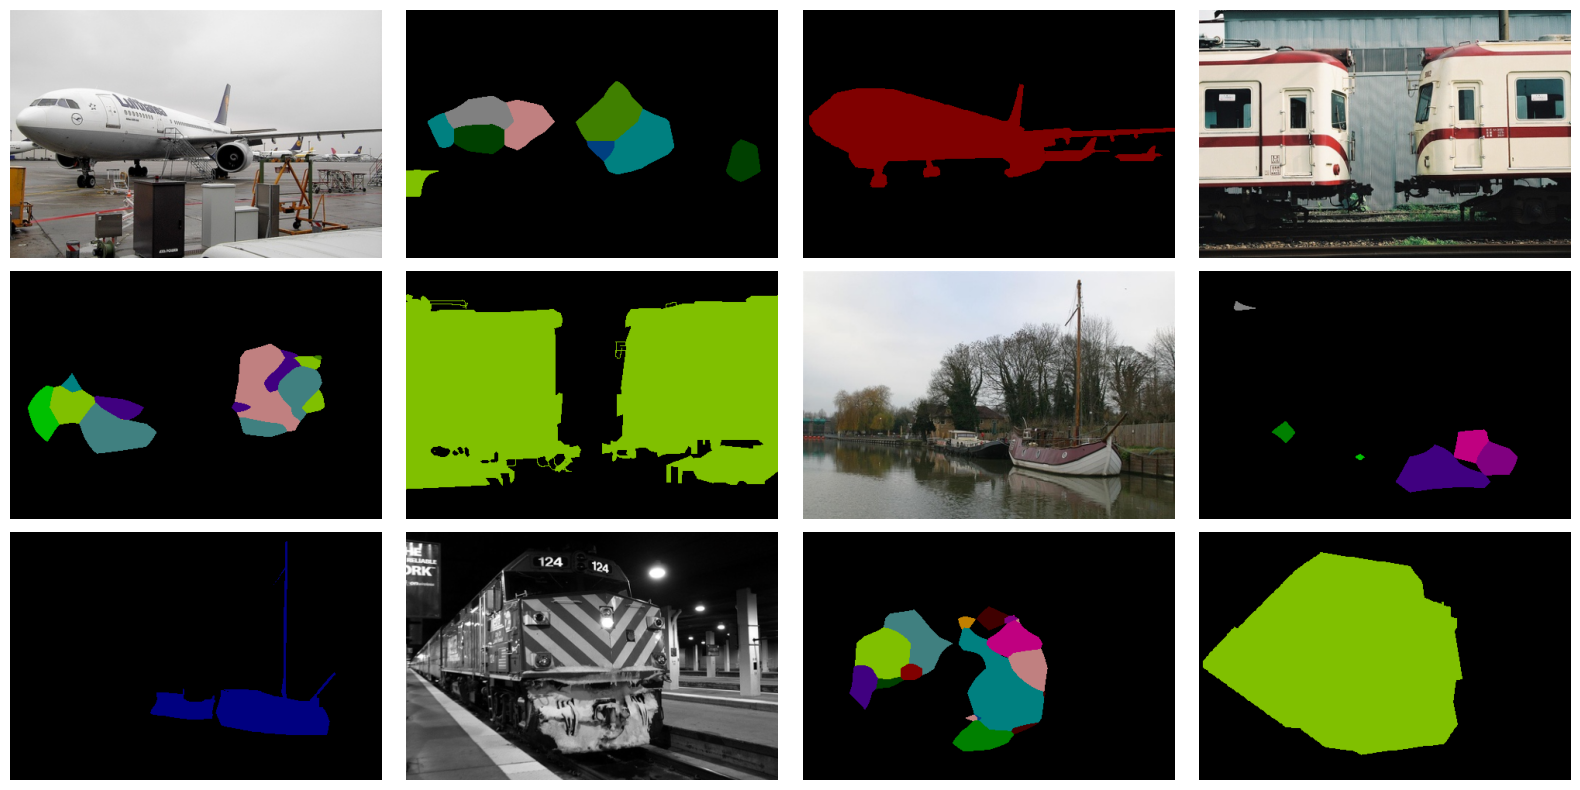

In [11]:
import torch # [语法]: 导入 torch 库。 [作用]: 深度学习框架的核心，提供 Tensor 操作和自动求导。
import torchvision # [语法]: 导入 torchvision 库。 [作用]: 提供计算机视觉相关的数据集、模型和工具。
import matplotlib.pyplot as plt # [语法]: 导入 matplotlib.pyplot 并起别名 plt。 [作用]: 强大的 Python 绘图库，用于显示图片。
import torchvision.transforms.functional as F # [语法]: 导入 torchvision 的函数式变换接口并起别名 F。 [作用]: 提供像 crop, resize 这样的具体图像操作函数，比 transforms.Compose 更灵活。

# ==========================================
# 1. 准备工作：定义颜色表和转换函数
# ==========================================

# [语法]: 定义一个嵌套列表 (List[List[int]])。
# [作用]: Pascal VOC 数据集的官方颜色映射表。
# 每一个子列表代表一个类别 (0~20) 的 RGB 颜色值。例如 [0,0,0] 是背景，[128,0,0] 是飞机。
VOC_COLORMAP = [
    [0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0], [0, 0, 128], [128, 0, 128],
    [0, 128, 128], [128, 128, 128], [64, 0, 0], [192, 0, 0], [64, 128, 0], [192, 128, 0],
    [64, 0, 128], [192, 0, 128], [64, 128, 128], [192, 128, 128], [0, 64, 0], [128, 64, 0],
    [0, 192, 0], [128, 192, 0], [0, 64, 128]
]

# [语法]: 定义函数 label2image，参数 pred 是预测出来的类别索引矩阵。
# [作用]: 将包含类别 ID (0, 1, 2...) 的二维矩阵，转换为包含 RGB 颜色的三维图片。
def label2image(pred):

    # [语法]: torch.tensor(..., device=...)。
    # [作用]: 将上面的 Python 列表 VOC_COLORMAP 转换为存储在 GPU (devices[0]) 上的 Tensor，方便后续查表。
    colormap = torch.tensor(VOC_COLORMAP, device=device)
    
    # [语法]: .long() 类型转换。
    # [作用]: 确保预测值是长整型 (int64)，因为 PyTorch 规定只有长整型才能作为索引去 tensor 里查值。
    X = pred.long()
    
    # [语法]: 张量高级索引 colormap[indices, :]。
    # [作用]: 查表操作。
    # 对于 X 中的每一个像素值（比如 1），去 colormap 这一行取出对应的 RGB ([128, 0, 0])。
    # 结果形状从 (H, W) 变为 (H, W, 3)。
    return colormap[X, :]

# ==========================================
# 2. 准备反归一化 (为了显示原图)
# ==========================================

# [语法]: 创建 Tensor 并进行 .view() 变形和 .to() 设备迁移。
# [作用]: 定义标准化时的均值。
# .view(3, 1, 1) 是为了将形状变为 (Channel, H, W) 的广播形式，方便后续和图片直接相加。
# 注意permute只能乾坤大多移动，然而，view却是能捏造数据，只要总数不变
MEAN = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1).to(device)

# [语法]: 同上。
# [作用]: 定义标准化时的方差。
STD = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1).to(device)

# [语法]: 定义函数 unnormalize。
# [作用]: 执行反标准化操作，将经过 ImageNet 标准化处理的图片还原回原始的 RGB 色彩空间。
# 公式：原图 = (标准化后的图 * 方差) + 均值。
def unnormalize(img_tensor):
    #img_tensor是(3,H,W)
    return img_tensor * STD + MEAN

# ==========================================
# 3. 循环预测并收集结果
# ==========================================

# [语法]: 多变量赋值。
# [作用]: n=4 表示我们要展示 4 张图片；imgs=[] 是一个空列表，用于收集即将生成的 [原图, 预测图, 标签图]。
n, imgs = 4, []

# [语法]: for 循环。
# [作用]: 循环 4 次，处理前 4 个样本。
for i in range(n):
    
    # [语法]: 解包赋值 (Unpacking)。
    # [作用]: 从测试数据集 voc_test 中获取第 i 个样本。
    # X 是图片 Tensor (已标准化)，Y 是标签 Tensor。
    X, Y = voc_test[i]
    
    # [语法]: .to(device)。
    # [作用]: 将数据搬运到 GPU 上，以便模型进行推理。
    X, Y = X.to(device), Y.to(device)

    # [语法]: 定义元组 (Top, Left, Height, Width)。
    # [作用]: 设定裁剪区域，这里表示从 (0,0) 开始，裁剪出 320x480 的区域。
    # 这通常是因为显存限制或为了统一展示尺寸。
    crop_rect = (0, 0, 320, 480)
    
    # [语法]: F.crop(img, *crop_rect) 使用解包参数调用函数。必须解包，不能传元组！！！
    # [作用]: 对输入图片 X 进行裁剪。F 是 torchvision.transforms.functional。
    X_crop = F.crop(X, *crop_rect)
    
    # [语法]: 同上。
    # [作用]: 对标签图片 Y 进行同样的裁剪，保证图片和标签是对齐的。
    Y_crop = F.crop(Y, *crop_rect)

    # [语法]: 链式调用：增加维度 -> 模型推理 -> 找最大值索引 -> 减少维度。
    # [作用]: 执行预测。
    # 1. .unsqueeze(0): 增加 Batch 维度 [1, 3, 320, 480]。
    # 2. net(...): 前向传播，得到 Logits。
    # 3. .argmax(dim=1): 获取概率最大的类别索引。
    # 4. .squeeze(0): 去掉 Batch 维度，得到 (320, 480) 的预测图。
    pred = net(X_crop.unsqueeze(0)).argmax(dim=1).squeeze(0)
    
    # [语法]: 函数调用 + .cpu()。
    # [作用]: 将预测的索引矩阵转换为彩色图片，并搬回 CPU 内存（因为 matplotlib 只能画 CPU 上的数据）。
    pred_img = label2image(pred).cpu()
    
    # [语法]: 同上。
    # [作用]: 将真实的标签索引矩阵也转换为彩色图片，并搬回 CPU。
    # Y_crop.squeeze(0) 是为了去掉存在的 Channel=1 维度。
   # [语法]: .clone() 克隆数据
    # [作用]: 先复制一份标签，避免修改原始数据。
    Y_vis = Y_crop.squeeze(0).clone()
    # [语法]: 布尔索引赋值 (Masking)
    # [作用]: 找到所有等于 255 (边缘/无效区域) 的像素，把它们强行改成 0 (背景)。
    # 这样 255 就变成了 0，不会导致数组越界了。
    Y_vis[Y_vis == 255] = 0

    # [语法]: 调用 label2image
    # [作用]: 现在传入的是干净的数据 (只有 0~20)，安全通过！
    label_img = label2image(Y_vis).cpu()
    
    # [语法]: 链式调用：反标准化 -> 维度置换 -> 转 CPU。
    # [作用]: 处理原图以便展示。
    # 1. unnormalize: 恢复颜色。
    # 2. .permute(1, 2, 0): 将 Tensor 从 (C, H, W) 转换为 (H, W, C)，这是 matplotlib 要求的格式。
    raw_img = unnormalize(X_crop).permute(1, 2, 0).cpu()

    # [语法]: 列表拼接 += [...]。
    # [作用]: 将处理好的 [原图, 预测图, 真实标签] 按顺序添加到 imgs 列表中。
    # 直接接在末尾 ,比如 [1,2] + [3,4] = [1,2,3,4]
    imgs += [raw_img, pred_img, label_img]

# ==========================================
# 4. 使用 Matplotlib 画图 (替代 d2l.show_images)
# ==========================================

# [语法]: plt.subplots(...) 创建子图。
# [作用]: 创建一个大画布，包含 3 行 n 列 (即 3x4=12) 个子图。
# figsize=(n * 4, 8) 设置画布的总宽和总高。
fig, axes = plt.subplots(3, n, figsize=(n * 4, 8))

# [语法]: for 循环 + zip + flatten。
# [作用]: 同时遍历所有的子图对象 (ax) 和图片数据 (img)。
# axes.flatten() 将 3x4 的二维数组展平成包含 12 个对象的一维数组，方便一一对应。
for ax, img in zip(axes.flatten(), imgs):
    
    # [语法]: ax.imshow(img)。
    # [作用]: 在当前的子图块上绘制图片。
    ax.imshow(img)
    
    # [语法]: ax.axis('off')。
    # [作用]: 关闭坐标轴和刻度显示，让图片展示更干净。
    ax.axis('off')

# [语法]: plt.tight_layout()。
# [作用]: 自动调整子图之间的间距，防止图片重叠。
plt.tight_layout()

# [语法]: plt.show()。
# [作用]: 渲染并显示最终的图像窗口。
plt.show()